## Recreating the Master Unit List

#### setup/imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa
import logging
import sys
from copy import deepcopy

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

#### defining a table grabbing object

In [5]:
class compile_tables(object):
    
    def __init__(self, pudl_engine, freq=None, start_date=None, end_date=None):
        """
        initializing a table compiler
        """
        self.pudl_engine = pudl_engine
        self.freq = freq

        if start_date is None:
            self.start_date = \
                pd.to_datetime(
                    '{}-01-01'.format(min(pc.working_years['eia923'])))
        else:
            # Make sure it's a date... and not a string.
            self.start_date = pd.to_datetime(start_date)

        if end_date is None:
            self.end_date = \
                pd.to_datetime(
                    '{}-12-31'.format(max(pc.working_years['eia923'])))
        else:
            # Make sure it's a date... and not a string.
            self.end_date = pd.to_datetime(end_date)

        if not pudl_engine:
            raise AssertionError('PudlTabl object needs a pudl_engine')
        self.pudl_engine = pudl_engine

        # grabing the metadata object for the sqlite db
        self.pt = pudl.output.pudltabl.get_table_meta(self.pudl_engine)
        
        self.pudl_out = pudl.output.pudltabl.PudlTabl(
            pudl_engine=pudl_engine, freq=self.freq)
        
        self._dfs = {
            'generation_fuel_eia923': None,
            'fuel_receipts_costs_eia923': None,
            'generators_eia860': None,
            'boiler_generator_assn_eia860': None,
            'generation_eia923': None,

            'fuel_cost': None,
        }

    
    def grab_the_table(self, table):
        if table is None:
            return 

        if self._dfs[table] is None:
            # this is going to try to see if the table is in the db
            # if pt[table] is not None:
            try:
                tbl = pt[table]
                print(f'   grabbing {table} from the sqlite db')
                select = sa.sql.select([tbl, ])
                if self.start_date is not None:
                    select = select.where(
                        tbl.c.report_date >= self.start_date)
                if self.end_date is not None:
                    select = select.where(
                        tbl.c.report_date <= self.end_date)
                                    
                df = pd.read_sql(select, self.pudl_engine, parse_dates=['report_date'], index_col=['id'])
                
                # the generators table has a ton of tables.. we are
                # going to exclude some of the tables that we don't need
                if table == 'generators_eia860':
                    cols = ['report_date','capacity_mw',
                            'summer_capacity_mw',
                            'winter_capacity_mw']+freq_ag_cols[table]
                    df = df[cols]
            
                # the bga table has no sumable data cols and is already reported annually
                if self.freq is not None and table != 'boiler_generator_assn_eia860':
                    by = freq_ag_cols[table] + [pd.Grouper(freq=self.freq)]
                    # Create a date index for temporal resampling:
                    df = (df.set_index(pd.DatetimeIndex(df.report_date)).
                          groupby(by=by).agg(pudl.helpers.sum_na).
                          reset_index())
                
                self._dfs[table] = df
                
            # if is it not a database table, it is an output function
            # elif hasattr(pudl_out_eia, table):
            except KeyError:
                # getattr turns the string of the table into an attribute
                # of the object, so this runs the output function
                print(f'   grabbing {table} from the output object')
                self._dfs[table] = getattr(self.pudl_out, table)()
        return self._dfs[table]

In [6]:
freq_ag_cols = {
    'generation_eia923': ['plant_id_eia','generator_id'],
    'generation_fuel_eia923': ['plant_id_eia','nuclear_unit_id',
                               'fuel_type','fuel_type_code_pudl',
                               'fuel_type_code_aer','prime_mover_code'],
    'fuel_receipts_costs_eia923': ['plant_id_eia','contract_type_code',
                                   'contract_expiration_date','energy_source_code',
                                   'fuel_type_code_pudl','fuel_group_code',
                                   'fuel_group_code_simple', 'supplier_name'],
    'generators_eia860': ['plant_id_eia','generator_id','operational_status_code',
                          #'operational_status','ownership_code',
                          'energy_source_code_1',
                          'technology_description',
                          #'energy_source_code_2','energy_source_code_3',
                          #'energy_source_code_4','energy_source_code_5',
                          #'energy_source_code_6','fuel_type_code_pudl',
                          #'multiple_fuels','deliver_power_transgrid',
                          #'syncronized_transmission_grid',
                          #'uprate_derate_during_year',
                          #'uprate_derate_completed_date',
                          #'current_planned_operating_date',
                          #'summer_estimated_capability_mw',
                          #'winter_estimated_capability_mw',
                          #'operating_switch','retirement_date',                         
                        ],
    'boiler_generator_assn_eia860': ['plant_id_eia','generator_id',
                                     'boiler_id','unit_id_eia','unit_id_pudl',
                                     'bga_source'],
    
}

In [7]:
def grab_denormalize_table(table, denorm_table=None, denorm_cols=None, id_cols=None, indicator=False):
    """
    Grab and denormalize the table.
    
    Grab the table that you want, and merge it with another table based
    on the 'denorm_cols'.
    
    Args:
        table (string): a table name
        denorm_table (string): the name of the table you want to merge in
        denorm_cols (list): the columns to use to merge the tables
        indicator (bool): True of False for whether or not you want to
            include an indicator column in your merge that notes where
            each row came from.
        id_cols (list): the list of columns that identify the plant
            granularity.
    Returns:
        pandas.Dataframe
    """
    table_df = table_compiler.grab_the_table(table)
    if denorm_table:
        logger.info(f'   denormalizing {table}')
        # denormalize the plant granularity
        table_df = table_df.merge(table_compiler.grab_the_table(denorm_table)
                                  .drop_duplicates(subset=set(id_cols + denorm_cols)),
                                  on=denorm_cols,
                                  how='outer',
                                  indicator=indicator)
    return table_df

In [8]:
plant_granularities = {    
    'plant': {
        'id_cols': ['plant_id_eia'],
        'ag_tables': {
            'fuel_cost':{ 
                'denorm_table': None,
                'denorm_cols': None,
                'ag_cols':{
                    'fuel_cost_per_mwh': 'mean',
                    },
            },
            'generation_fuel_eia923': {
                'denorm_table': None,
                'denorm_cols': None,
                'ag_cols': {
                    'fuel_consumed_mmbtu': pudl.helpers.sum_na,
                    #'net_generation_mwh': pudl.helpers.sum_na,
                    },
            },
            'generation_eia923': {
                'denorm_table': None,
                'denorm_cols': None,
                'ag_cols':{
                    'net_generation_mwh': pudl.helpers.sum_na,
                },
            },
            'fuel_receipts_costs_eia923': {
                'denorm_table': None,
                'denorm_cols': None,
                'ag_cols': {
                    'fuel_cost_per_mmbtu': pudl.helpers.sum_na,
                    },
            },
            'generators_eia860': {
                'denorm_table': None,
                'denorm_cols': None,
                'ag_cols': {            
                    'capacity_mw': pudl.helpers.sum_na,
                    },
            },
        }
    },
    'plant_gen': {
        'id_cols': ['plant_id_eia','generator_id'],
        # unit_id_pudl are associated with plant_id's and plant_id's/generator_id's
        'ag_tables': {
            'generators_eia860': {
                'denorm_table': None, 
                'denorm_cols': None,
                'ag_cols': {
                    'capacity_mw': pudl.helpers.sum_na,
                },
            },
            'generation_eia923': {
                'denorm_table': None, 
                'denorm_cols': None,
                'ag_cols': {
                    'net_generation_mwh': pudl.helpers.sum_na,
                },
            },
            'fuel_cost':{ 
                'denorm_table': None,
                'denorm_cols': None,
                'ag_cols':{
                    'fuel_cost_per_mwh': 'mean',
                    'heat_rate_mmbtu_mwh': 'mean',
                    },
            },
        },
    },
    'plant_unit': {
        'id_cols': ['plant_id_eia','unit_id_pudl'],
        # unit_id_pudl are associated with plant_id's and plant_id's/generator_id's
        'ag_tables': {
            'generators_eia860': {
                'denorm_table': 'boiler_generator_assn_eia860',
                'denorm_cols': ['plant_id_eia','generator_id', 'report_date'],
                'ag_cols': {
                    'capacity_mw': pudl.helpers.sum_na,
                },
            },
            'generation_fuel_eia923': {
                'denorm_table': 'boiler_generator_assn_eia860',
                'denorm_cols': ['plant_id_eia', 'report_date'],
                'ag_cols': {
                    'fuel_consumed_mmbtu': pudl.helpers.sum_na,
                },
            },
            'generation_eia923': {
                'denorm_table': 'boiler_generator_assn_eia860',
                'denorm_cols': ['plant_id_eia', 'generator_id', 'report_date'],
                'ag_cols':{
                    'net_generation_mwh': pudl.helpers.sum_na,
                },
            },
            'fuel_cost': {
                'denorm_table': 'boiler_generator_assn_eia860',
                'denorm_cols': ['plant_id_eia','generator_id', 'report_date'],
                'ag_cols': {
                    'fuel_cost_per_mwh': pudl.helpers.sum_na,
                },

            }

        },
    },
    'plant_technology': {
        # Note: I took out the 'generator_id' in the id_cols because
        # when the generator_id was in there, the aggreagations were
        # essentially at the generator level.
        'id_cols': ['plant_id_eia', 'technology_description'],
        'ag_tables': {
            'generators_eia860': {
                'denorm_table': None,
                'denorm_cols': None,
                'ag_cols': {
                    'capacity_mw': pudl.helpers.sum_na,
                },
            },
             'generation_eia923': {
                'denorm_table': 'generators_eia860',
                'denorm_cols': ['plant_id_eia','generator_id', 'report_date'],
                'ag_cols': {
                    'net_generation_mwh': pudl.helpers.sum_na,
                },
            },
        },
    },
    #'plant_prime_fuel': {
    #    'id_cols': ['plant_id_eia','energy_source_code_1'],
    #    'ag_tables': {        
    #    }
    #}
    
}

In [9]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
pt = pudl.output.pudltabl.get_table_meta(pudl_engine)

In [10]:
table_compiler = compile_tables(pudl_engine, freq='AS')

In [11]:
compiled_dfs = {}
for plant_gran in plant_granularities:
    logger.info(f'compiling data for {plant_gran}')
    cols_to_grab = plant_granularities[plant_gran]['id_cols'] + ['report_date']
    all_the_stuff = pd.DataFrame(columns=cols_to_grab)
    for table, table_details in plant_granularities[plant_gran]['ag_tables'].items():
        # grab the table
        logger.info(f'   begining the aggregation for {table}')
        all_the_stuff = (
            # grab the table
            grab_denormalize_table(
                table,
                denorm_table=table_details['denorm_table'],
                denorm_cols=table_details['denorm_cols'],
                id_cols=plant_granularities[plant_gran]['id_cols'],
            ).
            groupby(cols_to_grab).
            # use the groupby object to aggregate on the ag_cols
            # this runs whatever function we've defined in the 
            # ag_cols dictionary
            agg(table_details['ag_cols']).
            # reset the index because the output of the agg
            reset_index().
            # merge the new table into the compiled df
            merge(all_the_stuff, how='outer', on=cols_to_grab)
        ) 
    # add the df into a dictionary of dfs
    compiled_dfs[plant_gran] = all_the_stuff

compiling data for plant
   begining the aggregation for fuel_cost
   grabbing fuel_cost from the output object


/Users/christinagosnell/miniconda3/envs/pudl-rmi/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


   begining the aggregation for generation_fuel_eia923
   grabbing generation_fuel_eia923 from the sqlite db
   begining the aggregation for generation_eia923
   grabbing generation_eia923 from the sqlite db
   begining the aggregation for fuel_receipts_costs_eia923
   grabbing fuel_receipts_costs_eia923 from the sqlite db
   begining the aggregation for generators_eia860
   grabbing generators_eia860 from the sqlite db
compiling data for plant_gen
   begining the aggregation for generators_eia860
   begining the aggregation for generation_eia923
   begining the aggregation for fuel_cost
compiling data for plant_unit
   begining the aggregation for generators_eia860
   denormalizing generators_eia860
   grabbing boiler_generator_assn_eia860 from the sqlite db
   begining the aggregation for generation_fuel_eia923
   denormalizing generation_fuel_eia923
   begining the aggregation for generation_eia923
   denormalizing generation_eia923
   begining the aggregation for fuel_cost
   denor

In [12]:
# various tables to poke at for debuging
generat860 = table_compiler.grab_the_table('generation_eia923')
gens860 = table_compiler.grab_the_table('generators_eia860')
plant_df = compiled_dfs['plant']
plant_unit_df = compiled_dfs['plant_unit']
gens860_denorm = grab_denormalize_table(
    'generators_eia860',
    id_cols=plant_granularities['plant_unit']['id_cols'] ,
    denorm_cols=plant_granularities['plant_unit']['ag_tables']['generators_eia860']['denorm_cols'],
    denorm_table=plant_granularities['plant_unit']['ag_tables']['generators_eia860']['denorm_table'])

   denormalizing generators_eia860


In [32]:
def plot_plant_vs_agg(compiled_dfs, field, xy_limits, scale):
    """
    Make plots to compare FERC & EIA reported values for Coal & Gas plants.
    
    For each of the fields specified in fields_to_plot, create a pair of plots,
    one for 'gas' and one for 'coal' in the same frame, showing the EIA quantity
    vs. the FERC quantity in a scatter plot.
    """
    for plant_gran, df in compiled_dfs.items():
        field_plant = field+'_plant'
        field_gran = field+'_'+plant_gran
        try:
            merge_df = compiled_dfs['plant'].merge(df, on=['plant_id_eia', 'report_date'], suffixes=('_plant','_' + plant_gran))
            # this is for the try
            merge_df[field_gran]
            fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(11, 11))
            ax.scatter(merge_df[field_plant],
                       merge_df[field_gran],
                       color='black', alpha='0.1', label=field)
            ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
            ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
            ax.set_xscale(scale)
            ax.set_yscale(scale)
            ax.set_ylabel(f'{plant_gran} {field}')
            ax.set_xlabel(f'Plant {field}')
            ax.set_title(f"Plant vs {plant_gran}: {field}")
        except KeyError:
            pass

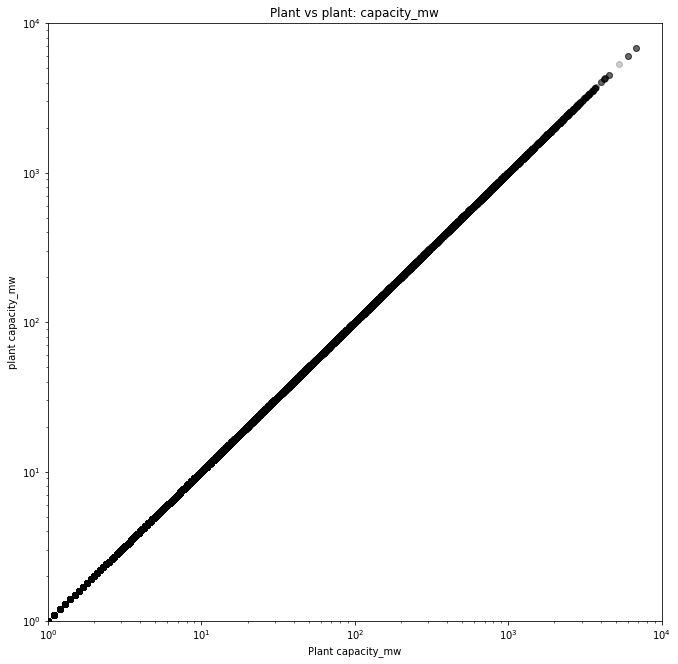

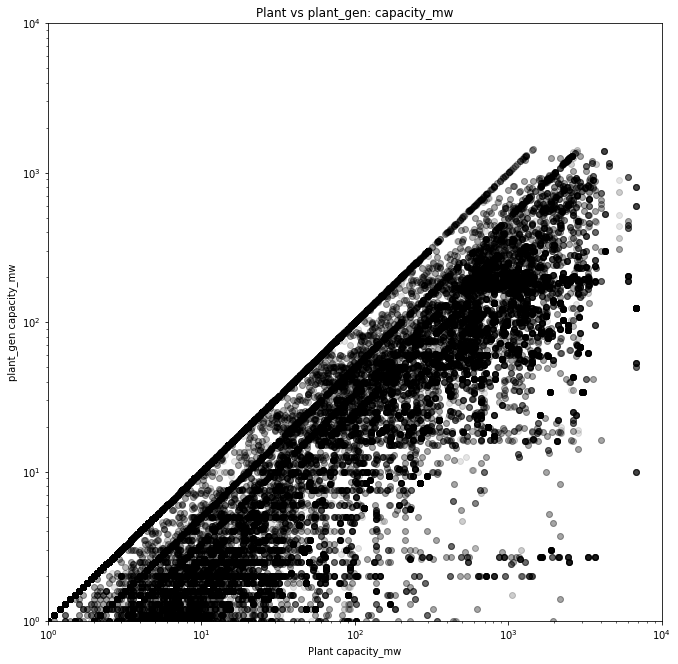

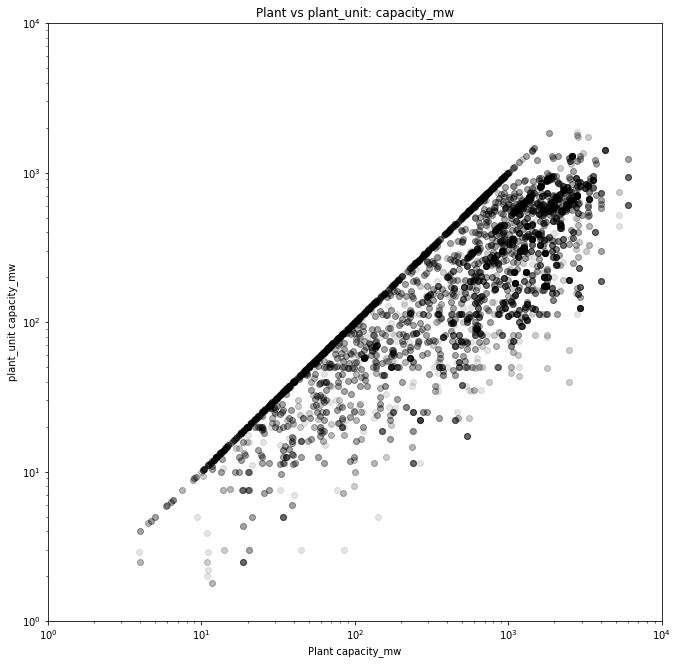

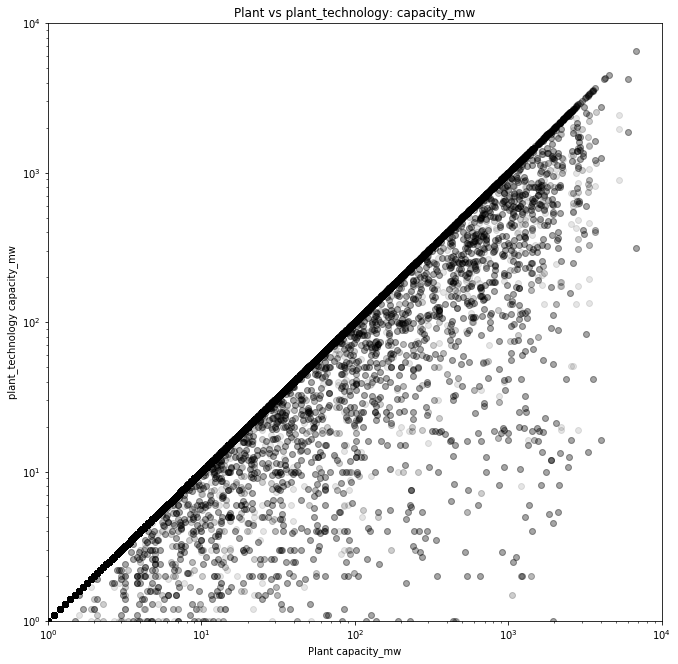

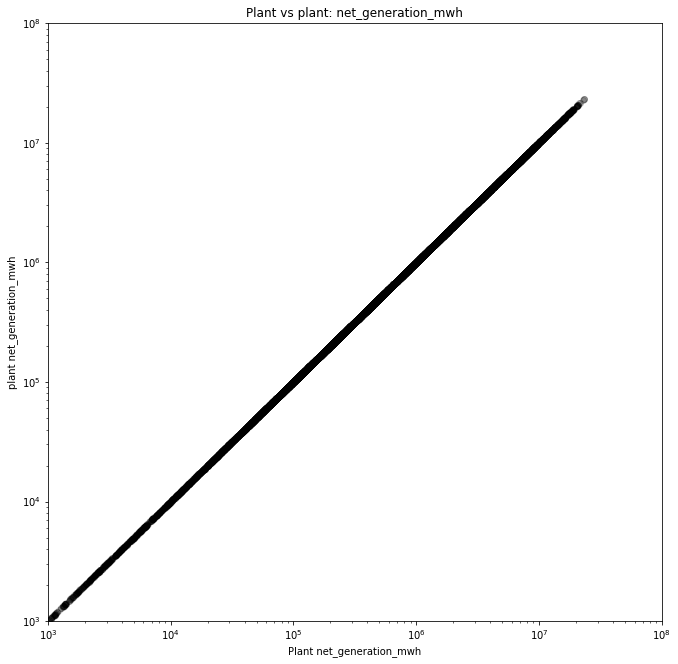

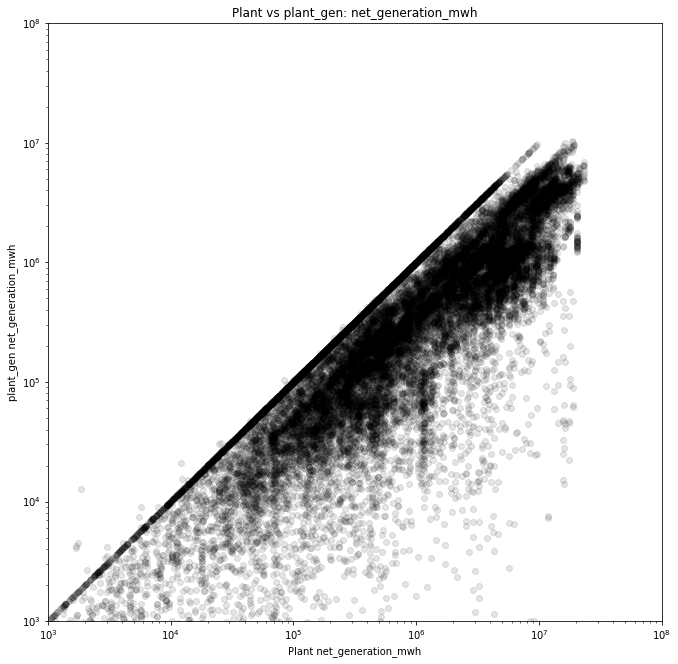

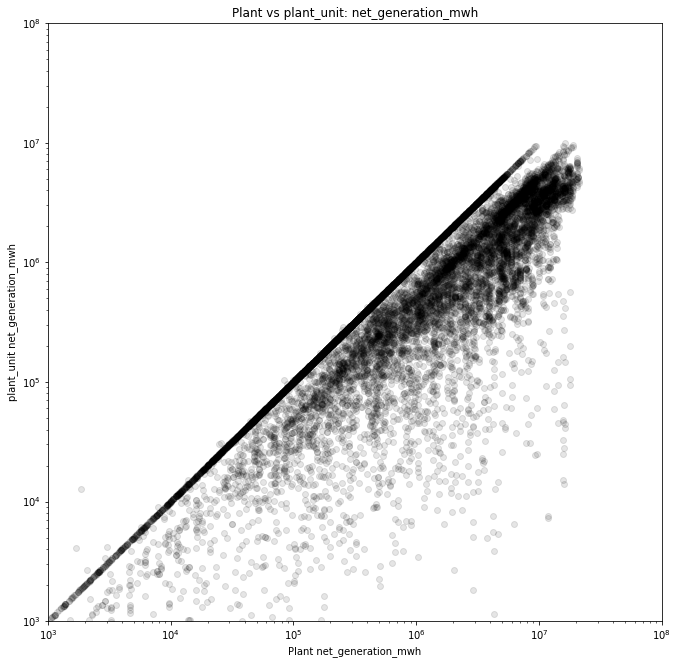

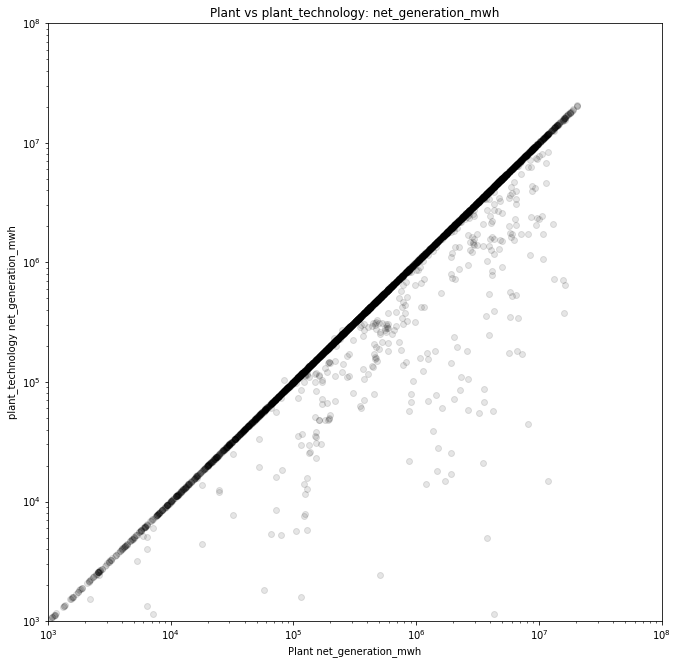

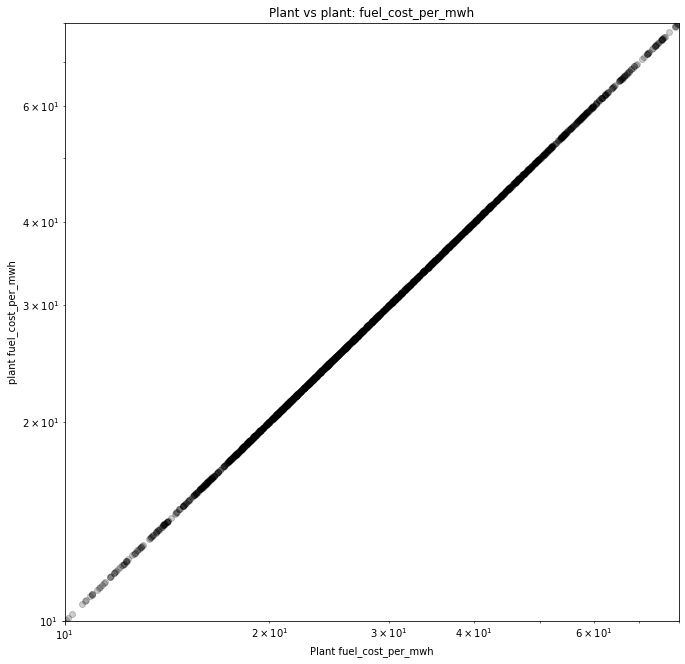

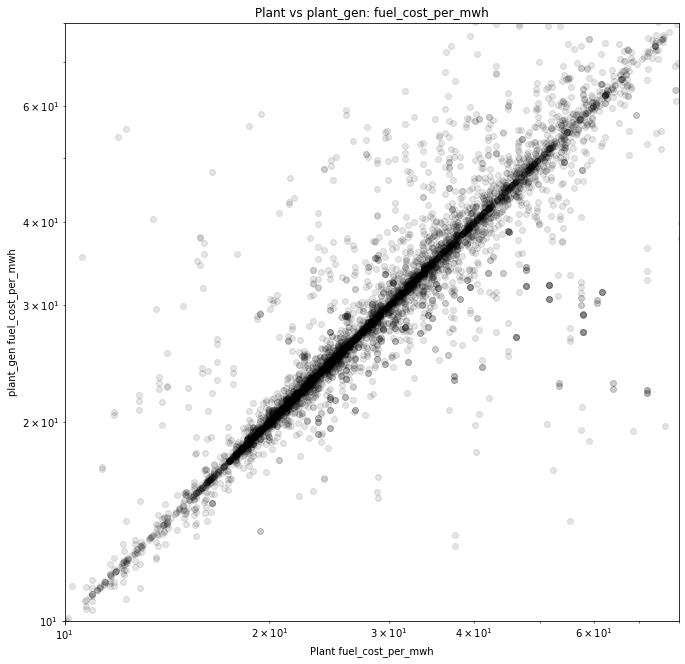

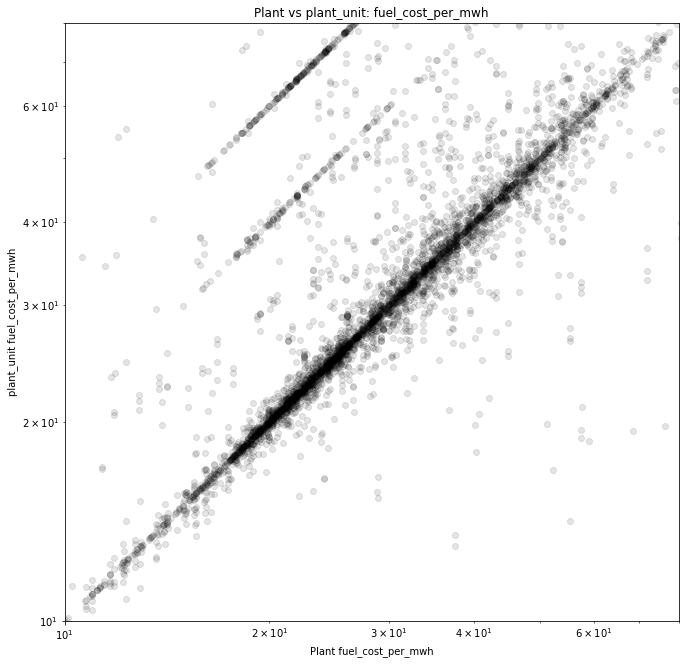

In [33]:
fields_to_plot = [
    # Simple Quantities
    'capacity_mw',
    #'opex_fuel',
    #'total_mmbtu',
    'net_generation_mwh',
    # Derived values
    #'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    #'fuel_cost_per_mmbtu', 
]

xy_limits = {
    # Simple Quantities
    'capacity_mw': (1e0, 1e4),
    'net_generation_mwh': (1e3,1e8),
    # Derived values
    'capacity_factor': (0,1.0),
    'heat_rate_mmbtu_mwh': (6,16),
    'fuel_cost_per_mwh': (10,80),
    'fuel_cost_per_mmbtu': (0,6),
}

for field in fields_to_plot:
    plot_plant_vs_agg(compiled_dfs,field, xy_limits, scale="log")
#plot_eia_v_ferc1(pudl_dude, fields_to_plot, xy_limits)

## Playing with the table compiler

In [15]:
table_compiler.grab_the_table('generators_eia860')

,plant_id_eia,generator_id,operational_status_code,energy_source_code_1,technology_description,report_date,capacity_mw,summer_capacity_mw,winter_capacity_mw
0,2,1,OP,WAT,Conventional Hydroelectric,2014-01-01,53.9,56.0,52.0
1,2,1,OP,WAT,Conventional Hydroelectric,2015-01-01,53.9,56.0,52.0
2,2,1,OP,WAT,Conventional Hydroelectric,2016-01-01,53.9,56.0,52.0
3,2,1,OP,WAT,Conventional Hydroelectric,2017-01-01,53.9,53.0,53.0
4,3,1,OP,BIT,Conventional Steam Coal,2014-01-01,153.1,138.0,138.0
...,...,...,...,...,...,...,...,...,...
102446,61956,GRDMT,T,SUN,Solar Photovoltaic,2017-01-01,4.4,4.4,4.4
102447,61956,TBESS,T,MWH,Batteries,2017-01-01,4.0,4.0,4.0
102448,61957,PW,T,WND,Onshore Wind Turbine,2017-01-01,243.0,220.0,220.0
102449,61958,BAP1,U,SUN,Solar Photovoltaic,2017-01-01,1.5,1.5,1.5


In [17]:
grab_denormalize_table('generation_eia923',
                       id_cols=['plant_id_eia','generator_id'],
                       denorm_table='boiler_generator_assn_eia860',
                       denorm_cols=['plant_id_eia','generator_id', 'report_date'],
                       indicator=True)

   denormalizing generation_eia923


,plant_id_eia,generator_id,report_date,net_generation_mwh,boiler_id,unit_id_eia,unit_id_pudl,bga_source,_merge
0,3,1,2009-01-01,221908.0,NaN,NaN,NaN,NaN,left_only
1,3,1,2010-01-01,435334.0,NaN,NaN,NaN,NaN,left_only
2,3,1,2011-01-01,312130.0,1,None,1.0,eia860_org,both
3,3,1,2012-01-01,152102.0,1,None,1.0,eia860_org,both
4,3,1,2013-01-01,30627.0,1,None,1.0,eia860_org,both
...,...,...,...,...,...,...,...,...,...
32056,60768,ST10,2016-01-01,NaN,2 A,PB2,1.0,eia860_org,both
32057,60768,ST10,2017-01-01,9504.0,2 A,PB2,1.0,eia860_org,both
32058,61761,GEN-1,2017-01-01,NaN,NaN,NaN,NaN,NaN,left_only
32059,61838,ST1,2017-01-01,NaN,NaN,NaN,NaN,NaN,left_only


## Trying the grouby/aggregation

In [18]:
# you can change these inputs and run the following cell
# to see what an aggregated dataframe with these inputs will
# result in.
table = 'generators_eia860'
denorm_table = None
denorm_cols = None
# the id_cols + report_date
id_cols = ['plant_id_eia', 'technology_description']
ag_cols = {'capacity_mw': pudl.helpers.sum_na,}

In [21]:
(grab_denormalize_table(
    table,
    denorm_table=denorm_table,
    denorm_cols=denorm_cols,
    id_cols=id_cols).
 groupby(id_cols + ['report_date']).
 agg(ag_cols).reset_index())

,plant_id_eia,technology_description,report_date,capacity_mw
0,2,Conventional Hydroelectric,2014-01-01,53.9
1,2,Conventional Hydroelectric,2015-01-01,53.9
2,2,Conventional Hydroelectric,2016-01-01,53.9
3,2,Conventional Hydroelectric,2017-01-01,53.9
4,3,Conventional Steam Coal,2014-01-01,1770.7
...,...,...,...,...
41696,61956,Batteries,2017-01-01,4.0
41697,61956,Solar Photovoltaic,2017-01-01,6.0
41698,61957,Onshore Wind Turbine,2017-01-01,243.0
41699,61958,Solar Photovoltaic,2017-01-01,1.5


## Playing with the compiled outputs 

In [22]:
# printing out the keys of the dictionary so you can see
# which 
compiled_dfs.keys()

dict_keys(['plant', 'plant_gen', 'plant_unit', 'plant_technology'])

In [23]:
plant_unit = compiled_dfs['plant_unit']

In [24]:
# if you want to look at an individaul plant
plant_unit[plant_unit['plant_id_eia'] == 3]

,plant_id_eia,unit_id_pudl,report_date,fuel_cost_per_mwh,net_generation_mwh,fuel_consumed_mmbtu,capacity_mw
0,3,1,2011-01-01,49.066847,312130.0,NaN,NaN
1,3,1,2012-01-01,53.815039,152102.0,NaN,NaN
2,3,1,2013-01-01,NaN,30627.0,NaN,NaN
3,3,1,2014-01-01,NaN,19614.0,NaN,153.1
4,3,1,2015-01-01,-132.311474,-1413.0,NaN,153.1
5,3,1,2016-01-01,NaN,7310.0,NaN,153.1
6,3,1,2017-01-01,91.082285,7221.0,NaN,153.1
7,3,2,2011-01-01,51.295507,191475.0,NaN,NaN
8,3,2,2012-01-01,56.845119,123410.0,NaN,NaN
9,3,2,2013-01-01,NaN,73425.0,NaN,NaN


In [25]:
# selecting on two criteria (plant_id_eia and report_date)
plant_unit[(plant_unit['plant_id_eia'] == 3) & (plant_unit['report_date'] == '2017-01-01')]

,plant_id_eia,unit_id_pudl,report_date,fuel_cost_per_mwh,net_generation_mwh,fuel_consumed_mmbtu,capacity_mw
6,3,1,2017-01-01,91.082285,7221.0,NaN,153.1
13,3,2,2017-01-01,82.770070,7498.0,NaN,153.1
26,3,4,2017-01-01,31.541425,722554.0,NaN,403.7
33,3,5,2017-01-01,28.684894,2710308.0,NaN,788.8
40,3,6,2017-01-01,70.373662,4199100.0,NaN,535.4
47,3,7,2017-01-01,69.408316,4217873.0,NaN,535.4


In [26]:
# you can see where fields are empty
plant_unit[plant_unit['capacity_mw'].isnull()]

,plant_id_eia,unit_id_pudl,report_date,fuel_cost_per_mwh,net_generation_mwh,fuel_consumed_mmbtu,capacity_mw
0,3,1,2011-01-01,49.066847,312130.00,NaN,NaN
1,3,1,2012-01-01,53.815039,152102.00,NaN,NaN
2,3,1,2013-01-01,NaN,30627.00,NaN,NaN
7,3,2,2011-01-01,51.295507,191475.00,NaN,NaN
8,3,2,2012-01-01,56.845119,123410.00,NaN,NaN
...,...,...,...,...,...,...,...
16727,58707,1,2013-01-01,NaN,5789.00,NaN,NaN
16741,59233,1,2013-01-01,NaN,NaN,NaN,NaN
16746,59254,1,2013-01-01,NaN,47388.38,NaN,NaN
16751,59338,1,2013-01-01,NaN,979382.00,NaN,NaN


In [27]:
# you can see where fields are not empty
plant_unit[plant_unit['capacity_mw'].notnull()]

,plant_id_eia,unit_id_pudl,report_date,fuel_cost_per_mwh,net_generation_mwh,fuel_consumed_mmbtu,capacity_mw
3,3,1,2014-01-01,NaN,19614.0,NaN,153.1
4,3,1,2015-01-01,-132.311474,-1413.0,NaN,153.1
5,3,1,2016-01-01,NaN,7310.0,NaN,153.1
6,3,1,2017-01-01,91.082285,7221.0,NaN,153.1
10,3,2,2014-01-01,NaN,18297.0,NaN,153.1
...,...,...,...,...,...,...,...
16778,60100,1,2017-01-01,NaN,0.0,NaN,11.5
16779,60122,1,2017-01-01,NaN,NaN,NaN,1230.3
16780,60340,1,2017-01-01,NaN,NaN,NaN,54.5
16781,60768,1,2016-01-01,NaN,NaN,NaN,619.0
